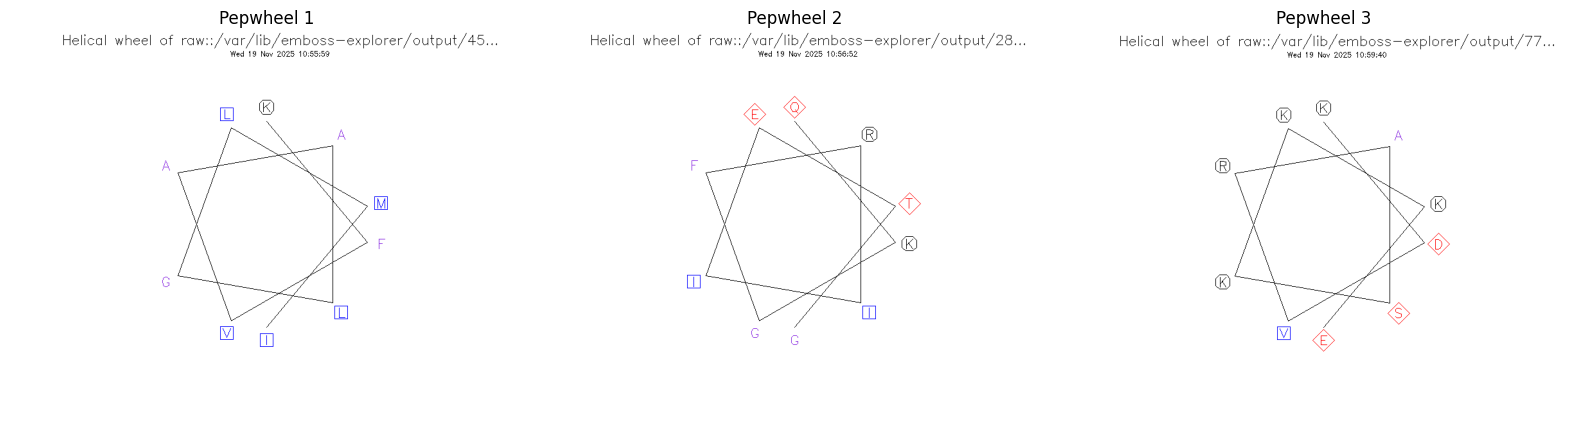

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Create three different sequences for the wheels, or use the one from fasta
seqs = [
    "K F V A A L G L M I", 
    "Q K G F R I I E T G",
    "K D V R A S K K K E" 
]

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for i, seq in enumerate(seqs):
    ax = axs[i]
    img_url = f"images/pepwheel_{i+1}.png"
    # Load and show image in the correct axes
    img = plt.imread(img_url)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Pepwheel {i+1}")

plt.tight_layout()
plt.show()


## H1 is highly hydrophobic
- Charge: Only 1 Lys (positive)
- Strong hydrophobic face → membrane insertion

## H2 is amphipathic
- Hydrophobic residues: Phe, Ile, Ile
- Charged residues: Lys (+), Arg (+), Glu (–)
- Mixed polar/hydrophobic

So it is in cytosolic OR membrane-surface amphipathic helix

## H3 is very charged so it is in cytosolic helix

# Secondary structure Prediction

In [ ]:
from Bio import SeqIO

# Chou-Fasman propensity data for alpha-helix (H) and beta-sheet (E)
chou_fasman_alpha = {
    'A': 1.42, 'R': 0.98, 'N': 0.67, 'D': 1.01, 'C': 0.70, 'Q': 1.11,
    'E': 1.51, 'G': 0.57, 'H': 1.00, 'I': 1.08, 'L': 1.21, 'K': 1.16,
    'M': 1.45, 'F': 1.13, 'P': 0.57, 'S': 0.77, 'T': 0.83, 'W': 1.08,
    'Y': 0.69, 'V': 1.06
}
chou_fasman_beta = {
    'A': 0.83, 'R': 0.93, 'N': 0.89, 'D': 0.54, 'C': 1.19, 'Q': 1.10,
    'E': 0.37, 'G': 0.75, 'H': 0.87, 'I': 1.60, 'L': 1.30, 'K': 0.74,
    'M': 1.05, 'F': 1.38, 'P': 0.55, 'S': 0.75, 'T': 1.19, 'W': 1.37,
    'Y': 1.47, 'V': 1.70
}

def predict_secondary_structure(sequence):
    pred = []
    for res in sequence:
        a = chou_fasman_alpha.get(res, 1.0)
        b = chou_fasman_beta.get(res, 1.0)
        if a > 1.03 and a > b:
            pred.append('H')
        elif b > 1.03:
            pred.append('E')
        else:
            pred.append('C')
    return ''.join(pred)

def fasta_secondary_structure(fasta_path):
    ss_result = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        seq = str(record.seq).upper()
        ss_result[record.id] = predict_secondary_structure(seq)
    return ss_result

fasta_ss = fasta_secondary_structure("secondary_structure.fasta")
for rid, ssseq in fasta_ss.items():
    print(f">{rid}\n{ssseq}")


>6VC8_1|Chains
CHEHEHEEEECHCCECHCHEEEHEEHCCEECHECCEEHCCECHHEEECCHEEEECEECEHCHHHECHHCCHEHCECHCEEEEEHECCEHCEHCECCECHHEHCEHCCHCECHEEECCHECECCCEECEHHHHCEHCCECECEEHECHHECHCECCHEEEEECHECHCHHH


The code calculates secondary structure using the Chou-Fasman method.
For each amino acid in the sequence:
- It looks up the alpha-helix (H) and beta-sheet (E) propensity values from the Chou-Fasman tables.
- If the residue has a higher-than-threshold alpha-helix propensity (>1.03) 
    and the propensity for helix is greater than for sheet, it's predicted as helix ('H').
- If not, but the beta-sheet propensity is >1.03, it's predicted as sheet ('E').
- Otherwise, it assigns coil ('C').


In [ ]:
actual = """
HELIX    1 AA1 GLY A   15  ASN A   26  1                             12    
HELIX    2 AA2 TYR A   71  GLY A   75  1                              5    
HELIX    3 AA3 ASN A   86  ASP A  105  1                             20    
HELIX    4 AA4 ASP A  126  GLY A  138  1                               13    
HELIX    5 AA5 GLY A  151  GLU A  168  1                               18    
SHEET    1 AA1 6 ASP A  38  ILE A  46  0                                        
SHEET    2 AA1 6 GLU A  49  ASP A  57 -1  O  ILE A  55   N  TYR A  40           
SHEET    3 AA1 6 THR A   2  GLY A  10  1  N  TYR A   4   O  ASP A  54           
SHEET    4 AA1 6 GLY A  77  ALA A  83  1  O  LEU A  79   N  VAL A   9           
SHEET    5 AA1 6 MET A 111  ASN A 116  1  O  ASN A 116   N  PHE A  82   
"""

# Decode the 'actual' secondary structure annotation and compare it with prediction

import re
from collections import OrderedDict

def parse_actual_secondary_structure(actual_str):
    """
    Parses 'actual' annotation string for helices and sheets, returns per-residue assignments.
    Returns: dict mapping residue index to 'H', 'E', or 'C'
    """
    helix_lines = [line for line in actual_str.strip().splitlines() if line.startswith('HELIX')]
    sheet_lines = [line for line in actual_str.strip().splitlines() if line.startswith('SHEET')]
    resid_to_ss = {}  # (chain, resnum) -> SS

    # Parse helix assignments
    for line in helix_lines:
        # e.g. HELIX    1 AA1 GLY A   15  ASN A   26  1     12
        m = re.match(r"HELIX\s+\d+\s+\S+\s+\S+\s+(\S)\s+(\d+)\s+\S+\s+(\S)\s+(\d+)", line)
        if m:
            chain1, start, chain2, end = m.group(1), int(m.group(2)), m.group(3), int(m.group(4))
            # Assume chain1 == chain2 in each HELIX (as is typical)
            for i in range(start, end+1):
                resid_to_ss[(chain1, i)] = 'H'

    # Parse sheet assignments
    for line in sheet_lines:
        # e.g. SHEET    1 AA1 6 ASP A  38  ILE A  46  0   
        m = re.match(r"SHEET\s+\d+\s+\S+\s+\d+\s+\S+\s+(\S)\s+(\d+)\s+\S+\s+(\S)\s+(\d+)", line)
        if m:
            chain1, start, chain2, end = m.group(1), int(m.group(2)), m.group(3), int(m.group(4))
            for i in range(start, end+1):
                # Only overwrite if not already helix
                if (chain1, i) not in resid_to_ss:
                    resid_to_ss[(chain1, i)] = 'E'
    # All others are coil
    # We can infer residue numbers from the FASTA (which starts at a certain index): secondary_structure.fasta sequence
    return resid_to_ss

# Find residue numbering offset by examining FASTA header and data, assume chain A and start at 1 or using actual annotation

fasta_path = "secondary_structure.fasta"

record = next(SeqIO.parse(fasta_path, "fasta"))
fasta_seq = str(record.seq)
first_resnum = None
chain_id = "A"

# Try to infer from actual BLOCK, otherwise default to 1
all_resnums = []
for line in actual.strip().splitlines():
    if line.startswith("HELIX") or line.startswith("SHEET"):
        fields = re.split(r"\s+", line)
        resnums = [int(s) for s in fields if s.isdigit()]
        all_resnums += resnums
if all_resnums:
    min_resnum = min(all_resnums)
    first_resnum = min_resnum
else:
    first_resnum = 1

# Map sequence indices to residue numbers
seq_to_resnum = OrderedDict()
for i in range(len(fasta_seq)):
    seq_to_resnum[i] = first_resnum + i

# Get true per-residue SS assignments
actual_ss_dict = parse_actual_secondary_structure(actual)
actual_ss_seq = []
for i in range(len(fasta_seq)):
    resnum = seq_to_resnum[i]
    k = (chain_id, resnum)
    s = actual_ss_dict.get(k, 'C') # default to coil
    actual_ss_seq.append(s)
actual_ss_seq = ''.join(actual_ss_seq)

# Compare with predicted
pred_ss_seq = list(fasta_ss.values())[0]

# Print comparison (first 80 residues for clarity)
print("\nComparison of predicted vs actual secondary structure (first 80 residues):")
print("Res#", "AA", "Pred", "Actual", sep="\t")
for i in range(min(80, len(fasta_seq))):
    print(f"{i+1}\t{fasta_seq[i]}\t{pred_ss_seq[i]}\t{actual_ss_seq[i]}")

# Calculate and print overall Q3 accuracy
matches = sum(1 for i in range(len(fasta_seq)) if pred_ss_seq[i] == actual_ss_seq[i])
q3 = matches / len(fasta_seq) * 100
print(f"\nQ3 accuracy: {q3:.1f}%")




Comparison of predicted vs actual secondary structure (first 80 residues):
Res#	AA	Pred	Actual
1	G	C	C
2	M	H	C
3	T	E	E
4	E	H	E
5	Y	E	E
6	K	H	E
7	L	E	E
8	V	E	E
9	V	E	E
10	V	E	E
11	G	C	E
12	A	H	C
13	G	C	C
14	G	C	C
15	V	E	C
16	G	C	H
17	K	H	H
18	S	C	H
19	A	H	H
20	L	E	H
21	T	E	H
22	I	E	H
23	Q	H	H
24	L	E	H
25	I	E	H
26	Q	H	H
27	N	C	H
28	H	C	C
29	F	E	C
30	V	E	C
31	D	C	C
32	E	H	C
33	Y	E	C
34	D	C	C
35	P	C	C
36	T	E	C
37	I	E	C
38	E	H	C
39	D	C	E
40	S	C	E
41	Y	E	E
42	R	C	E
43	K	H	E
44	Q	H	E
45	V	E	E
46	V	E	E
47	I	E	E
48	D	C	C
49	G	C	C
50	E	H	E
51	T	E	E
52	C	E	E
53	L	E	E
54	L	E	E
55	D	C	E
56	I	E	E
57	L	E	E
58	D	C	E
59	T	E	C
60	A	H	C
61	G	C	C
62	Q	H	C
63	E	H	C
64	E	H	C
65	Y	E	C
66	S	C	C
67	A	H	C
68	M	H	C
69	R	C	C
70	D	C	C
71	Q	H	C
72	Y	E	H
73	M	H	H
74	R	C	H
75	T	E	H
76	G	C	H
77	E	H	C
78	G	C	E
79	F	E	E
80	L	E	E

Q3 accuracy: 40.6%


In [3]:
# Also calculate and print Q3 accuracy for the first 50 amino acids
n_first = min(50, len(fasta_seq))
matches_first50 = sum(1 for i in range(n_first) if pred_ss_seq[i] == actual_ss_seq[i])
q3_first50 = matches_first50 / n_first * 100
print(f"Q3 accuracy (first 50 residues): {q3_first50:.1f}%")


Q3 accuracy (first 50 residues): 46.0%


# Domains and motifs

## Domains
1.	Kinase catalytic domain
2.	SH2 domain (phosphotyrosine-binding)
3.	Zinc-finger domain (C2H2 type)
4.	Immunoglobulin (Ig) domain
5.	Helix–turn–helix (HTH) transcription factor domain

## Motifs
## P‑loop motif

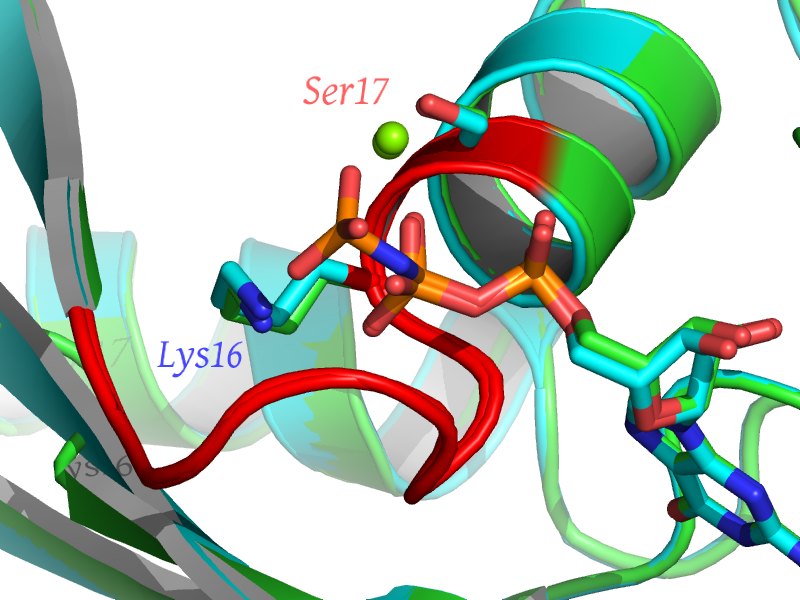

In [3]:
from IPython.display import Image, display

image_path = "images/motif_1.png"  # Change to your image file if needed
display(Image(filename=image_path))